In [1]:
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential,Model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense ,Dropout, BatchNormalization,Input
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.applications import VGG16

In [2]:
# 1. Loading and preprocessing the images
# Paths to folders
facial_emotions_path = "C:/Users/harie/huggies_model/facial_emotions"
emotion_recognition_path = "C:/Users/harie/huggies_model/emotion-recognition"
# Define a function to extract the label from filenames
def extract_label(filename):
    return filename.split('(')[0].strip()

In [3]:
# Data Augmentation
datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2
)


# 2. Create data generators
batch_size = 32
img_width, img_height = 64, 64 # you can adjust this depending on the size of your images

In [4]:
train_generator = datagen.flow_from_directory(
    facial_emotions_path,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='categorical',
    color_mode='grayscale',
    subset='training')

Found 26286 images belonging to 8 classes.


In [5]:
validation_generator = datagen.flow_from_directory(
    facial_emotions_path,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    color_mode='grayscale',
    class_mode='categorical',
    subset='validation')

Found 6568 images belonging to 8 classes.


In [6]:
# CNN Model
model = Sequential()

# First convolutional layer
model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(img_width, img_height, 1)))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

# Second convolutional layer
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

# Third convolutional layer
model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

# Flattening
model.add(Flatten())

# Full connection
model.add(Dense(512, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))
model.add(Dense(8, activation='softmax'))

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])



In [7]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 62, 62, 32)        320       
                                                                 
 batch_normalization (Batch  (None, 62, 62, 32)        128       
 Normalization)                                                  
                                                                 
 max_pooling2d (MaxPooling2  (None, 31, 31, 32)        0         
 D)                                                              
                                                                 
 dropout (Dropout)           (None, 31, 31, 32)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 29, 29, 64)        18496     
                                                                 
 batch_normalization_1 (Bat  (None, 29, 29, 64)        2

In [8]:
# Callbacks
early_stop = EarlyStopping(patience=10, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=1e-6)

# Training the model
history = model.fit(
    train_generator,
    epochs=50,
    validation_data=validation_generator,
    callbacks=[early_stop, reduce_lr]
)

Epoch 1/50
822/822 [==============================] - 133s 156ms/step - loss: 1.9028 - accuracy: 0.3612 - val_loss: 1.4421 - val_accuracy: 0.4703 - lr: 0.0010
Epoch 2/50
822/822 [==============================] - 125s 151ms/step - loss: 1.3915 - accuracy: 0.4895 - val_loss: 1.3086 - val_accuracy: 0.5151 - lr: 0.0010
Epoch 3/50
822/822 [==============================] - 120s 146ms/step - loss: 1.2601 - accuracy: 0.5392 - val_loss: 1.3846 - val_accuracy: 0.5105 - lr: 0.0010
Epoch 4/50
822/822 [==============================] - 124s 150ms/step - loss: 1.2070 - accuracy: 0.5551 - val_loss: 1.1197 - val_accuracy: 0.5812 - lr: 0.0010
Epoch 5/50
822/822 [==============================] - 123s 149ms/step - loss: 1.1544 - accuracy: 0.5760 - val_loss: 1.2485 - val_accuracy: 0.5454 - lr: 0.0010
Epoch 6/50
822/822 [==============================] - 124s 151ms/step - loss: 1.0982 - accuracy: 0.5988 - val_loss: 1.1703 - val_accuracy: 0.5738 - lr: 0.0010
Epoch 7/50
822/822 [==========================

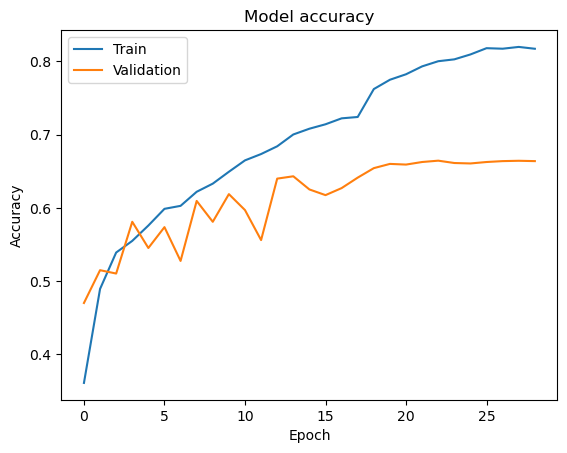

In [9]:
import matplotlib.pyplot as plt

# Plot training & validation accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()




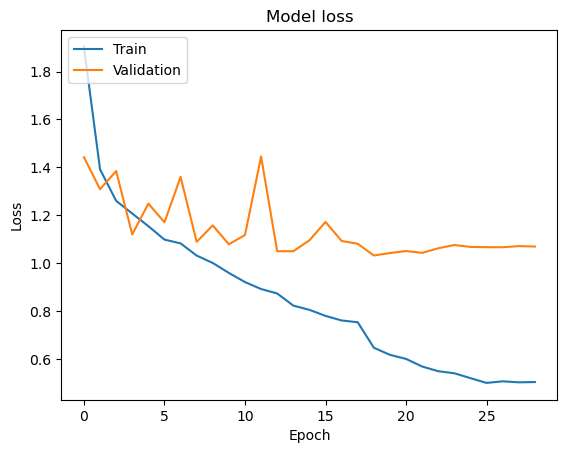

In [10]:
# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

In [11]:
model.save('emotion_model.h5')

C:\Users\harie\AppData\Roaming\Python\Python311\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [12]:
import numpy as np
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing import image
import matplotlib.pyplot as plt
import random
import os

In [13]:
# Load the saved model
loaded_model = load_model('emotion_model.h5')

In [14]:
def predict_emotion(img_path):
    # Load the image
    img = image.load_img(img_path, target_size=(img_width, img_height))
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)  # Convert single image to batch.
    img_array /= 255.  # Normalize to [0,1]
    
    # Predict the class
    predictions = loaded_model.predict(img_array)
    class_idx = np.argmax(predictions[0])
    class_label = list(train_generator.class_indices.keys())[class_idx]
    class_probabilities = predictions[0]  # The predicted probabilities for all classes
    return class_label, class_probabilities

In [15]:
facial_emotions_path = "C:/Users/harie/huggies_model/facial_emotions"

subfolders = [f for f in os.listdir(facial_emotions_path) if os.path.isdir(os.path.join(facial_emotions_path, f))]
chosen_subfolder = random.choice(subfolders)
images = [img for img in os.listdir(os.path.join(facial_emotions_path, chosen_subfolder)) if img.endswith('.png')]
chosen_image = random.choice(images)
test_image_path = os.path.join(facial_emotions_path, chosen_subfolder, chosen_image)

predicted_class, predicted_probs = predict_emotion(test_image_path)
formatted_probs = "\n".join([f"{label}: {prob*100:.2f}%" for label, prob in zip(train_generator.class_indices.keys(), predicted_probs)])

# Display the test image
plt.imshow(plt.imread(test_image_path))
plt.title(f"Image Name: {chosen_image}\nPredicted class: {predicted_class}\n{formatted_probs}")
plt.axis('off')  # Turn off the axis numbers
plt.show()

ValueError: in user code:

    File "C:\Users\harie\AppData\Roaming\Python\Python311\site-packages\keras\src\engine\training.py", line 2341, in predict_function  *
        return step_function(self, iterator)
    File "C:\Users\harie\AppData\Roaming\Python\Python311\site-packages\keras\src\engine\training.py", line 2327, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "C:\Users\harie\AppData\Roaming\Python\Python311\site-packages\keras\src\engine\training.py", line 2315, in run_step  **
        outputs = model.predict_step(data)
    File "C:\Users\harie\AppData\Roaming\Python\Python311\site-packages\keras\src\engine\training.py", line 2283, in predict_step
        return self(x, training=False)
    File "C:\Users\harie\AppData\Roaming\Python\Python311\site-packages\keras\src\utils\traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "C:\Users\harie\AppData\Roaming\Python\Python311\site-packages\keras\src\engine\input_spec.py", line 280, in assert_input_compatibility
        raise ValueError(

    ValueError: Exception encountered when calling layer 'sequential' (type Sequential).
    
    Input 0 of layer "conv2d" is incompatible with the layer: expected axis -1 of input shape to have value 1, but received input with shape (None, 64, 64, 3)
    
    Call arguments received by layer 'sequential' (type Sequential):
      • inputs=tf.Tensor(shape=(None, 64, 64, 3), dtype=float32)
      • training=False
      • mask=None


In [ ]:
import json

# ... your training code ...

# Save the class labels
with open('class_labels.json', 'w') as f:
    json.dump(train_generator.class_indices, f)
